# Binary Classification of Machine Failures
In this notebook, we will be building a binary classification model to predict if a machine will fail or not.
The dataset is from the Kaggle Competition [Binary Classification of Machine Failures](https://www.kaggle.com/competitions/playground-series-s3e17).

<div align="center">
<img src="https://www.kaggle.com/competitions/53376/images/header" />
</div>

## 1. Importing Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from tqdm.notebook import tqdm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


import warnings

### Configurations

In [3]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('darkgrid')

## 2. Loading Data

In [4]:
df = pd.read_csv('train.csv', index_col='id')

In [5]:
df.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
id,,,,,,,,,,,,,
0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [6]:
df.shape

(136429, 13)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 136429 entries, 0 to 136428
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Product ID               136429 non-null  object 
 1   Type                     136429 non-null  object 
 2   Air temperature [K]      136429 non-null  float64
 3   Process temperature [K]  136429 non-null  float64
 4   Rotational speed [rpm]   136429 non-null  int64  
 5   Torque [Nm]              136429 non-null  float64
 6   Tool wear [min]          136429 non-null  int64  
 7   Machine failure          136429 non-null  int64  
 8   TWF                      136429 non-null  int64  
 9   HDF                      136429 non-null  int64  
 10  PWF                      136429 non-null  int64  
 11  OSF                      136429 non-null  int64  
 12  RNF                      136429 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 14.6+ MB


In [8]:
df.isnull().sum()

Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [9]:
df.duplicated().sum()

np.int64(1134)

In [10]:
df.drop_duplicates(inplace=True)

## 3. Exploratory Data Analysis

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Air temperature [K],135295.0,299.863074,1.862655,295.3,298.3,300.0,301.2,304.4
Process temperature [K],135295.0,309.941071,1.384941,305.8,308.8,310.0,310.9,313.8
Rotational speed [rpm],135295.0,1520.339318,138.643328,1181.0,1432.0,1493.0,1580.0,2886.0
Torque [Nm],135295.0,40.341770,8.492636,3.8,34.6,40.4,46.1,76.6
Tool wear [min],135295.0,104.365224,63.945614,0.0,48.0,106.0,159.0,253.0
Machine failure,135295.0,0.015736,0.124453,0.0,0.0,0.0,0.0,1.0
TWF,135295.0,0.001537,0.039179,0.0,0.0,0.0,0.0,1.0
HDF,135295.0,0.005181,0.071795,0.0,0.0,0.0,0.0,1.0
PWF,135295.0,0.002365,0.048576,0.0,0.0,0.0,0.0,1.0
OSF,135295.0,0.003940,0.062642,0.0,0.0,0.0,0.0,1.0


In [12]:
df['Product ID'].nunique()

9976

In [13]:
df['Product ID'].value_counts()

Product ID
L53257    137
L49056    128
L48892    116
L54275    114
L53258    106
         ... 
L48089      1
H29557      1
M19631      1
L48200      1
L48036      1
Name: count, Length: 9976, dtype: int64

In [14]:
df['Type'].value_counts()

Type
L    94437
M    31976
H     8882
Name: count, dtype: int64

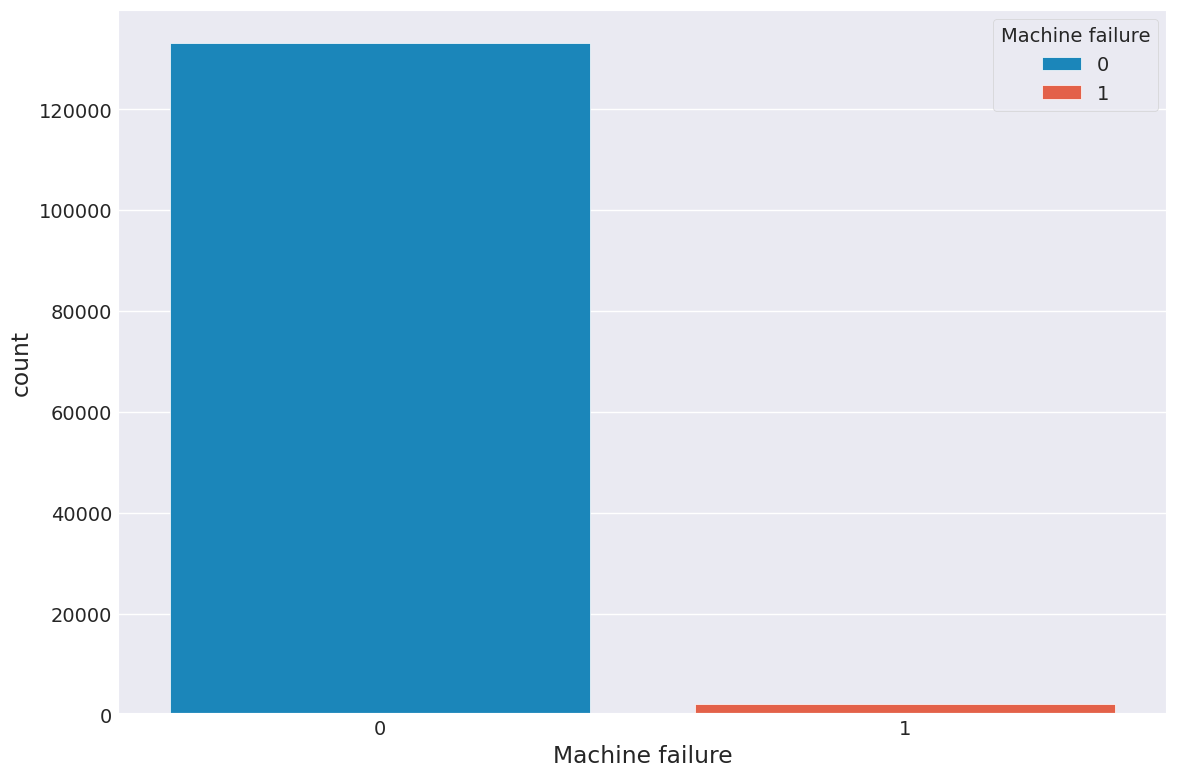

In [15]:
sns.countplot(x=df['Machine failure'], hue=df['Machine failure'])
plt.tight_layout()

In [16]:
df['Machine failure'].value_counts()

Machine failure
0    133166
1      2129
Name: count, dtype: int64

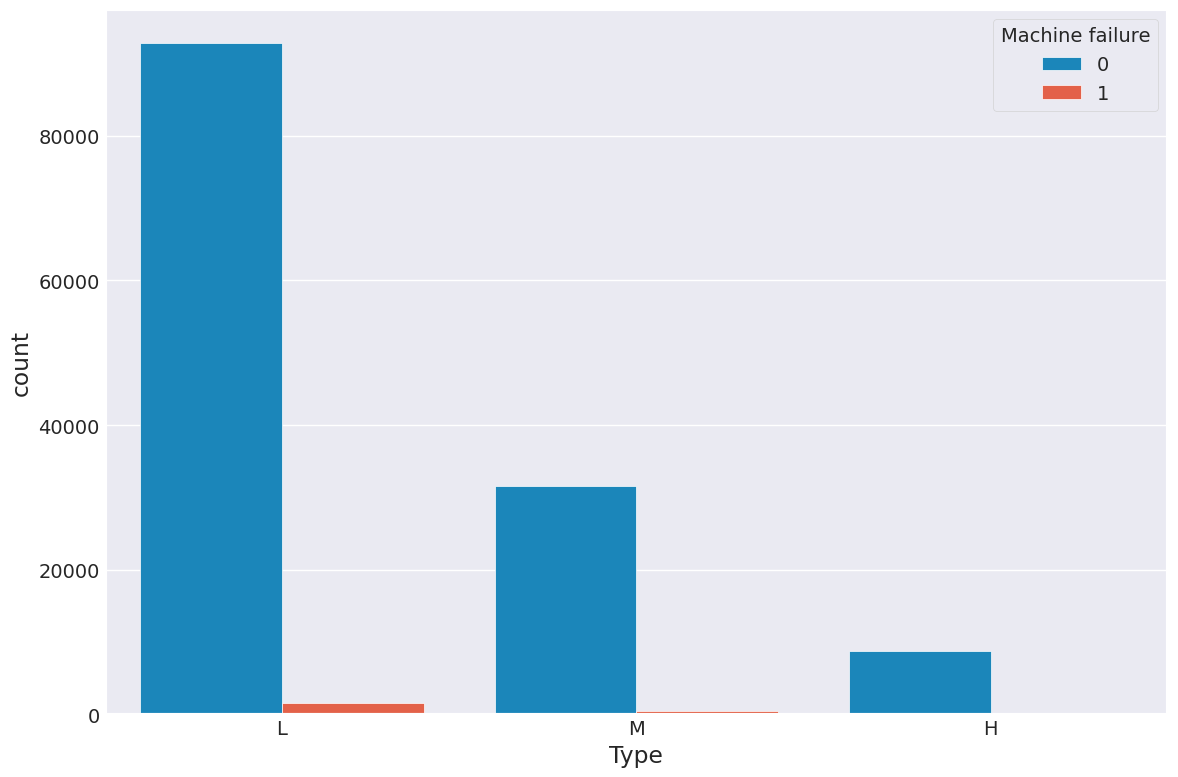

In [17]:
sns.countplot(x=df['Type'], hue=df['Machine failure'])
plt.tight_layout()

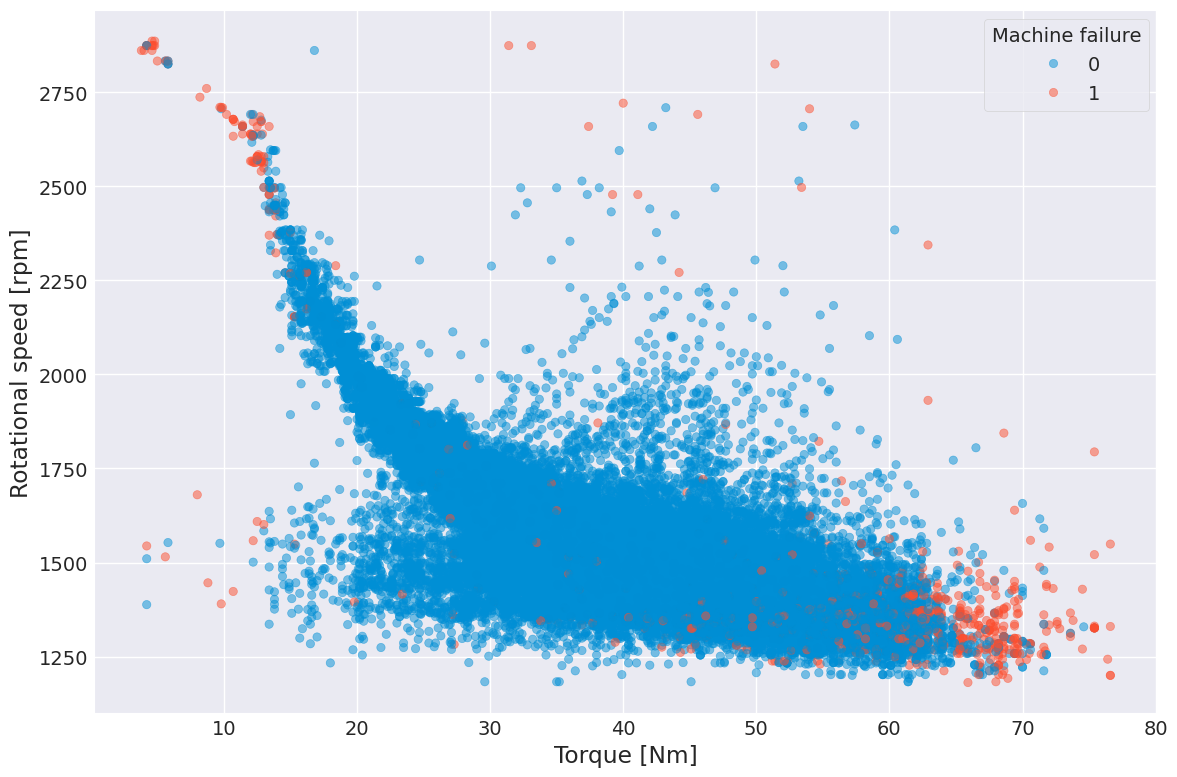

In [18]:
sns.scatterplot(
    df,
    x='Torque [Nm]',
    y='Rotational speed [rpm]',
    hue='Machine failure',
    edgecolor=None,
    alpha=0.5
)
plt.tight_layout()

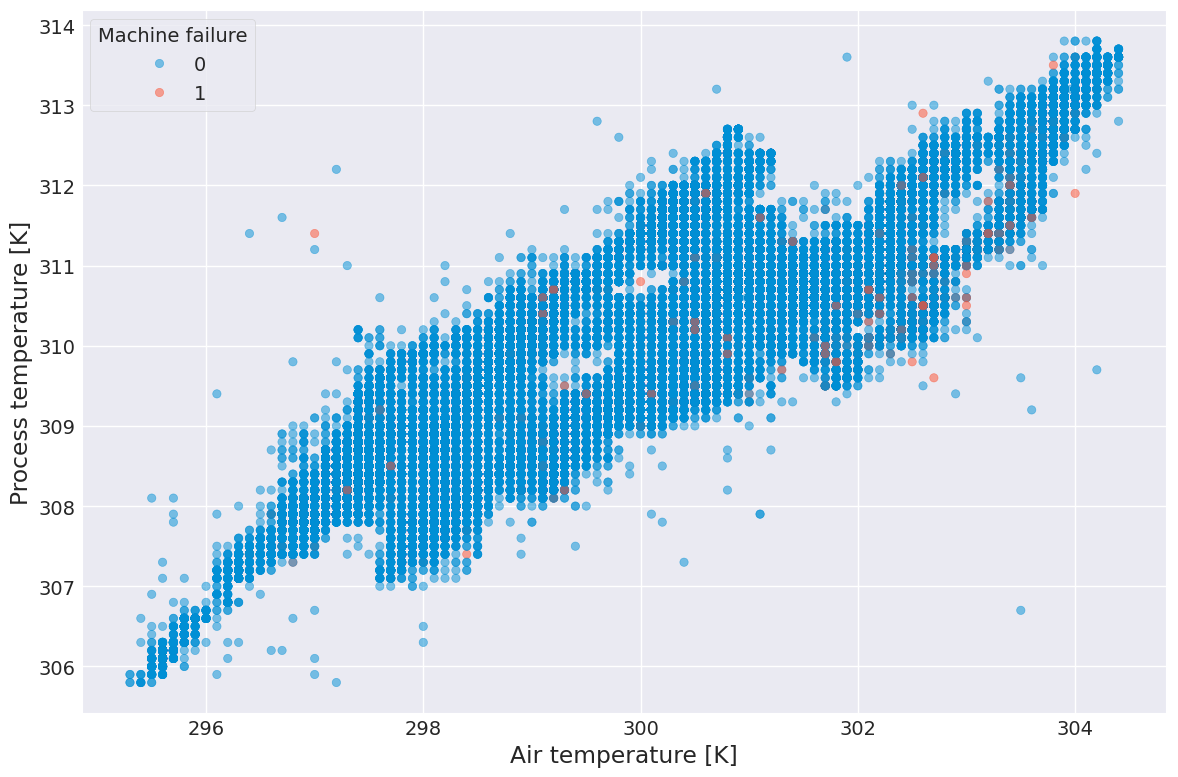

In [19]:
sns.scatterplot(
    df,
    x='Air temperature [K]',
    y='Process temperature [K]',
    hue='Machine failure',
    edgecolor=None,
    alpha=0.5
)
plt.tight_layout()

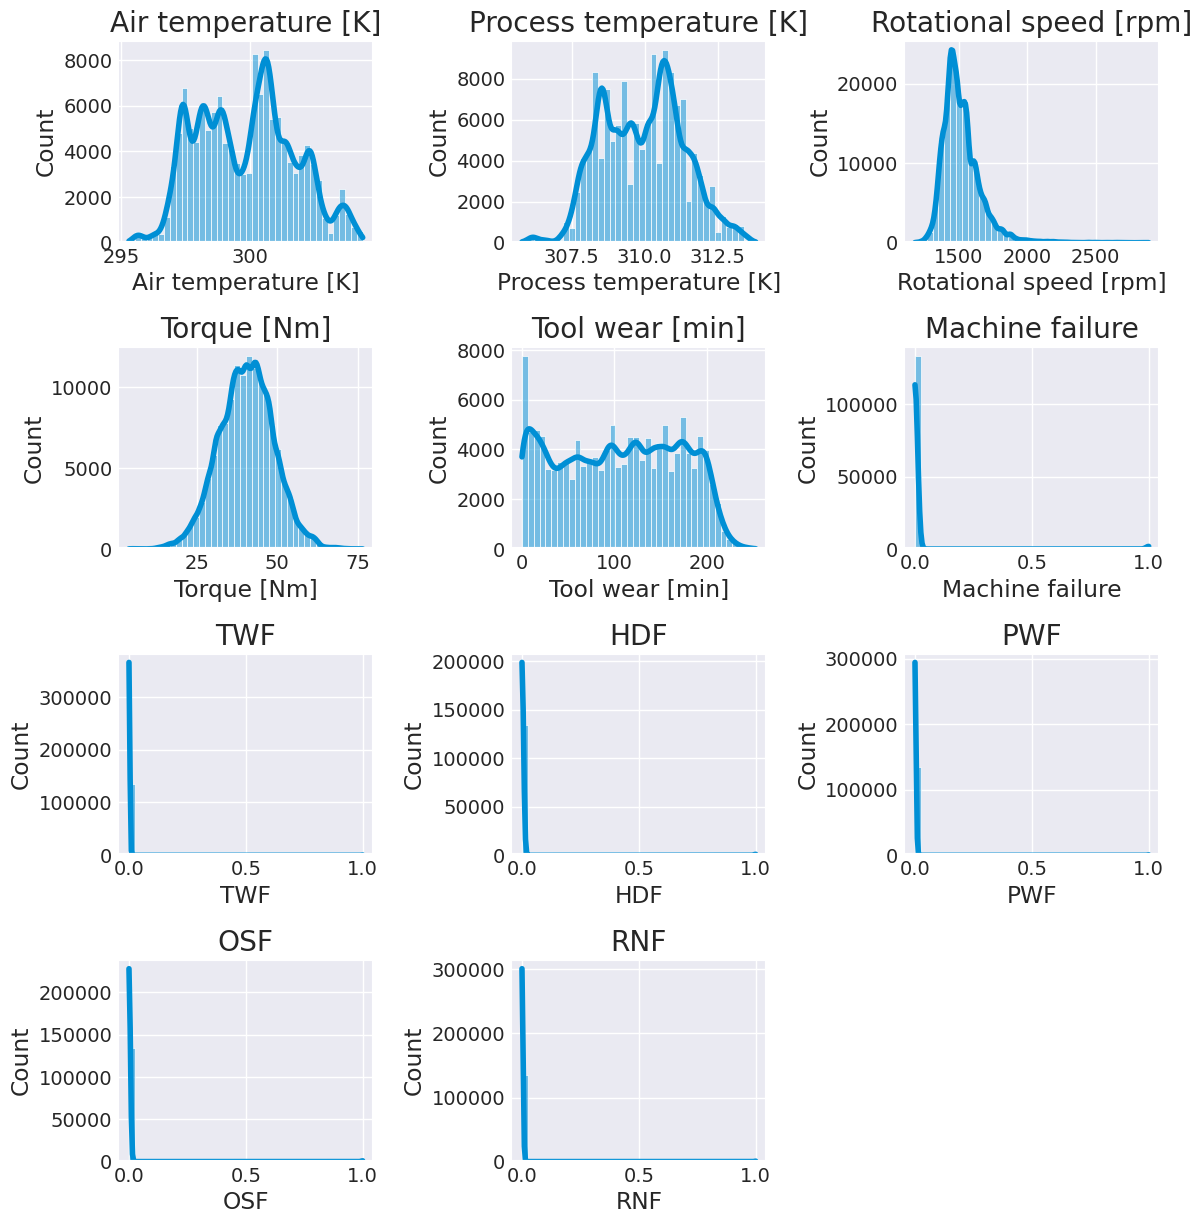

In [20]:
plt.figure(figsize=(12, 15))
for i, c in enumerate(df.columns[2:]):
    plt.subplot(5, 3, i+1)
    sns.histplot(df[c], bins=40, kde=True)
    plt.title(c)
plt.tight_layout()

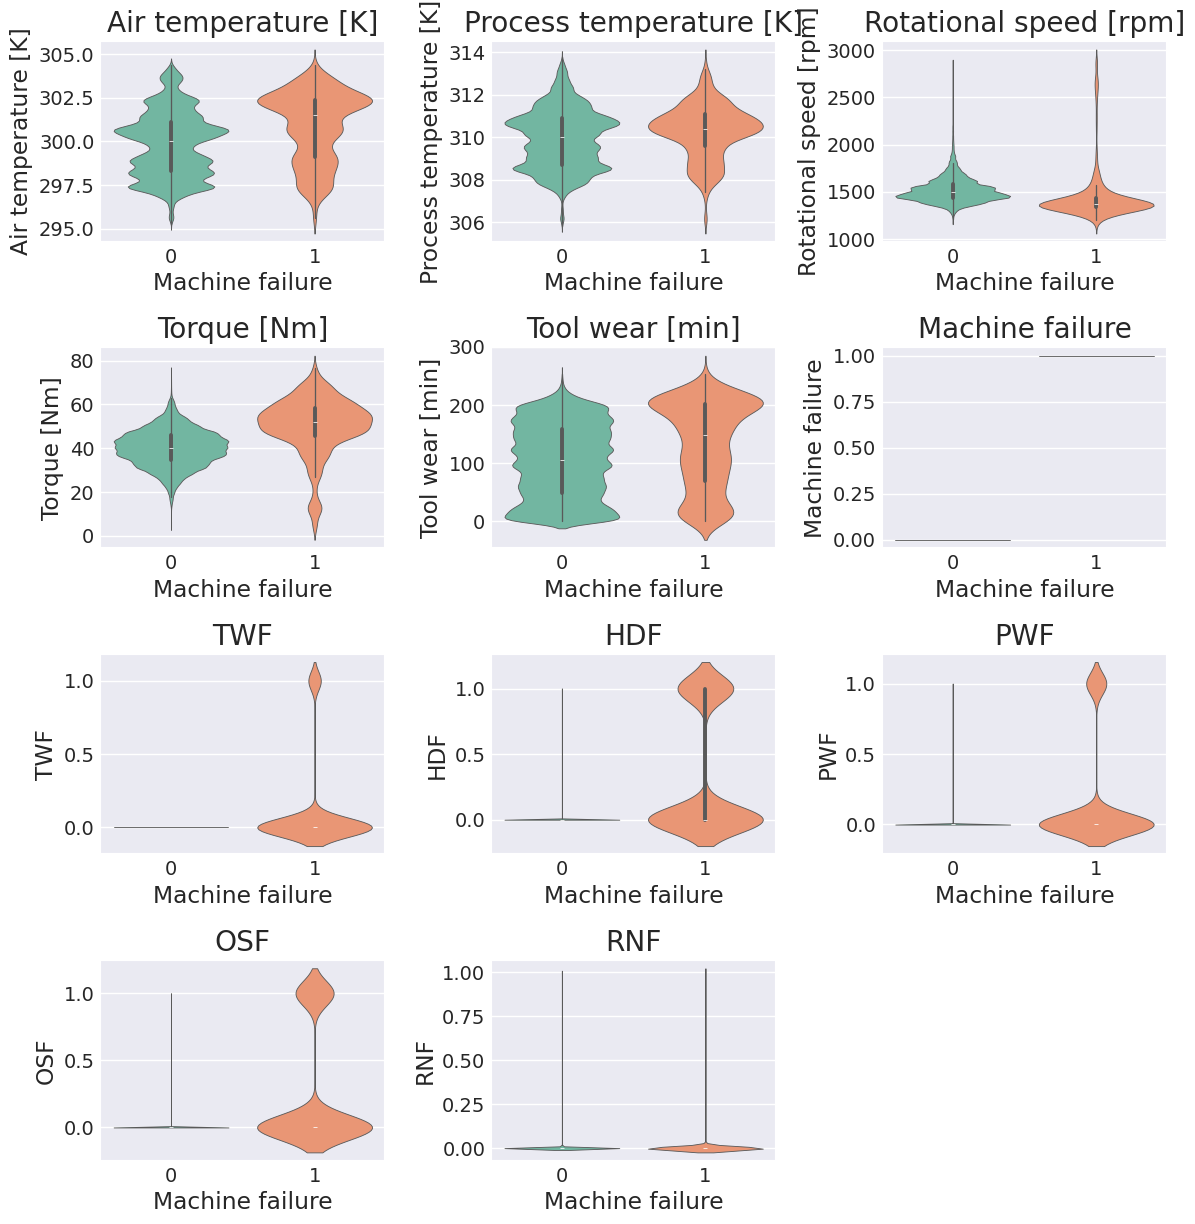

In [21]:
plt.figure(figsize=(12, 15))
for i, c in enumerate(df.columns[2:]):
    plt.subplot(5, 3, i+1)
    sns.violinplot(x=df['Machine failure'], y=df[c], palette='Set2')
    plt.title(c)
plt.tight_layout()

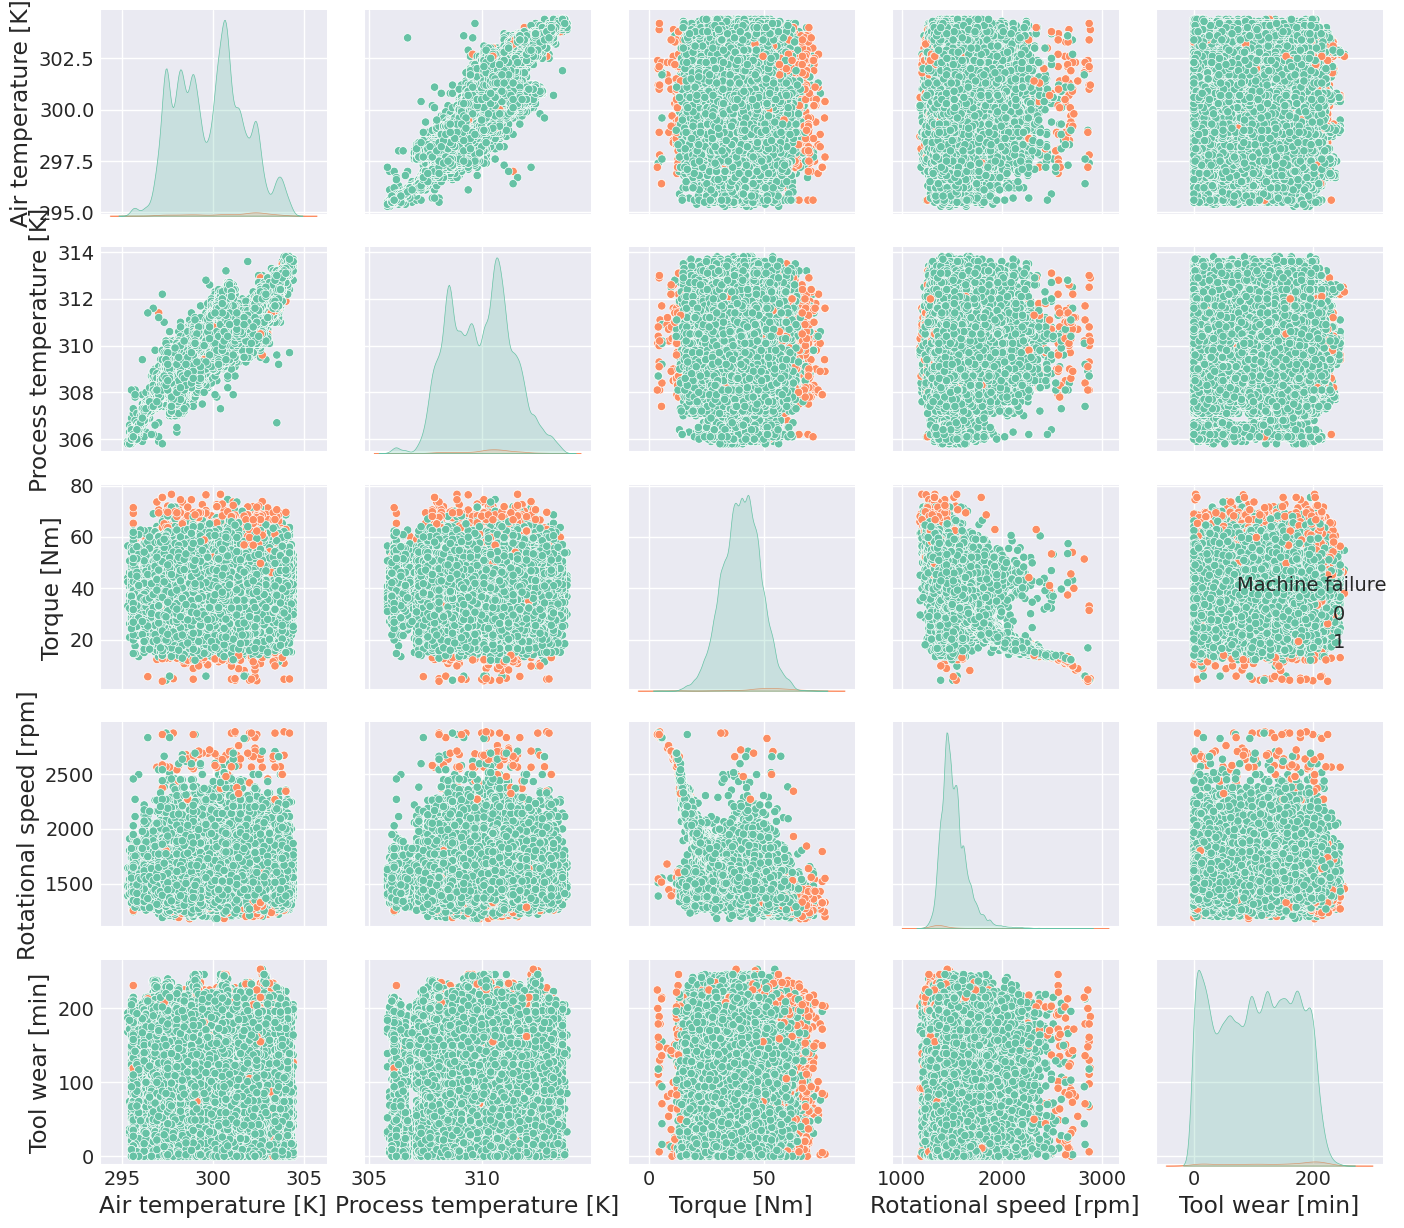

In [22]:
sns.pairplot(df[['Air temperature [K]', 'Process temperature [K]', 'Torque [Nm]', 'Rotational speed [rpm]', 'Tool wear [min]', 'Machine failure']], hue='Machine failure', palette='Set2')
plt.tight_layout()

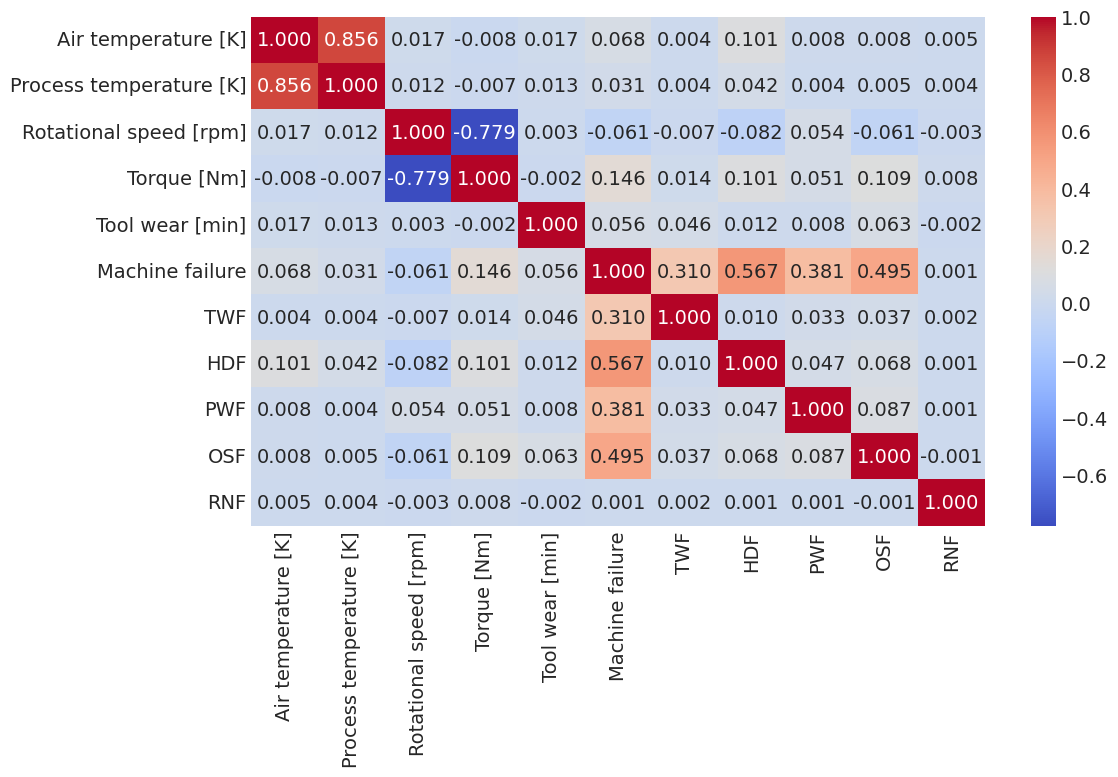

In [23]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.3f')
plt.tight_layout()

In [24]:
df.corr(numeric_only=True)['Machine failure'].sort_values(ascending=False)

Machine failure            1.000000
HDF                        0.566626
OSF                        0.494536
PWF                        0.381418
TWF                        0.310337
Torque [Nm]                0.146488
Air temperature [K]        0.068193
Tool wear [min]            0.056311
Process temperature [K]    0.031273
RNF                        0.001481
Rotational speed [rpm]    -0.061466
Name: Machine failure, dtype: float64

## 4. Data Preprocessing

In [25]:
# Downsampling the dataset to balance the classes
df_majority = df[df['Machine failure'] == 0]
df_minority = df[df['Machine failure'] == 1]
df_majority_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=42)
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_downsampled.shape

(4258, 13)

In [26]:
df = df_downsampled

In [27]:
df['Machine failure'].value_counts()

Machine failure
0    2129
1    2129
Name: count, dtype: int64

In [28]:
x = df.drop(columns=['Machine failure', 'Product ID', 'Type'])
y = df[['Machine failure']]

In [29]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

## 5. Model Training

In [36]:
models = {
    'GaussianNB': GaussianNB(),
    'MultinomialNB': MultinomialNB(),
    'BernoulliNB': BernoulliNB(),
    'LogisticRegression': LogisticRegression(),
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=5),
    'SVC': SVC(),
    'XGBClassifier': xgb.XGBClassifier(),
    'LightGBMClassifier': lgb.LGBMClassifier(verbose=-1)
}

def evaluate(x_train, y_train, x_test, y_test):
    results = []

    for i, (model_name, model) in enumerate(tqdm(models.items())):
        if 'random_state' in model.get_params():
            model.set_params(random_state=42)

        print(f'Training {model_name}...')
        y_pred = model.fit(x_train, y_train).predict(x_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')

        plt.subplot(3, 5, i+1)
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(model_name, fontsize=12)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()

        results.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })
        
    plt.suptitle('Confusion Matrices of All Models')
    plt.tight_layout()
    
    report = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
    report.reset_index(drop=True, inplace=True)
    return report

  0%|          | 0/12 [00:00<?, ?it/s]

Training GaussianNB...
Training MultinomialNB...
Training BernoulliNB...
Training LogisticRegression...
Training ExtraTreesClassifier...
Training DecisionTreeClassifier...
Training RandomForestClassifier...
Training GradientBoostingClassifier...
Training KNeighborsClassifier...
Training SVC...
Training XGBClassifier...
Training LightGBMClassifier...


,Model,Accuracy,Precision,Recall,F1 Score
0,RandomForestClassifier,0.910798,0.914689,0.908140,0.909923
1,ExtraTreesClassifier,0.910798,0.919190,0.906896,0.909501
2,GradientBoostingClassifier,0.909624,0.915041,0.906478,0.908582
3,XGBClassifier,0.904930,0.908125,0.902458,0.904062
4,LightGBMClassifier,0.900235,0.903348,0.897747,0.899325
5,SVC,0.896714,0.918367,0.890274,0.893931
6,LogisticRegression,0.890845,0.912536,0.884316,0.887860
7,KNeighborsClassifier,0.887324,0.896064,0.883064,0.885552
8,BernoulliNB,0.877934,0.906306,0.870324,0.873812
9,MultinomialNB,0.877934,0.906306,0.870324,0.873812


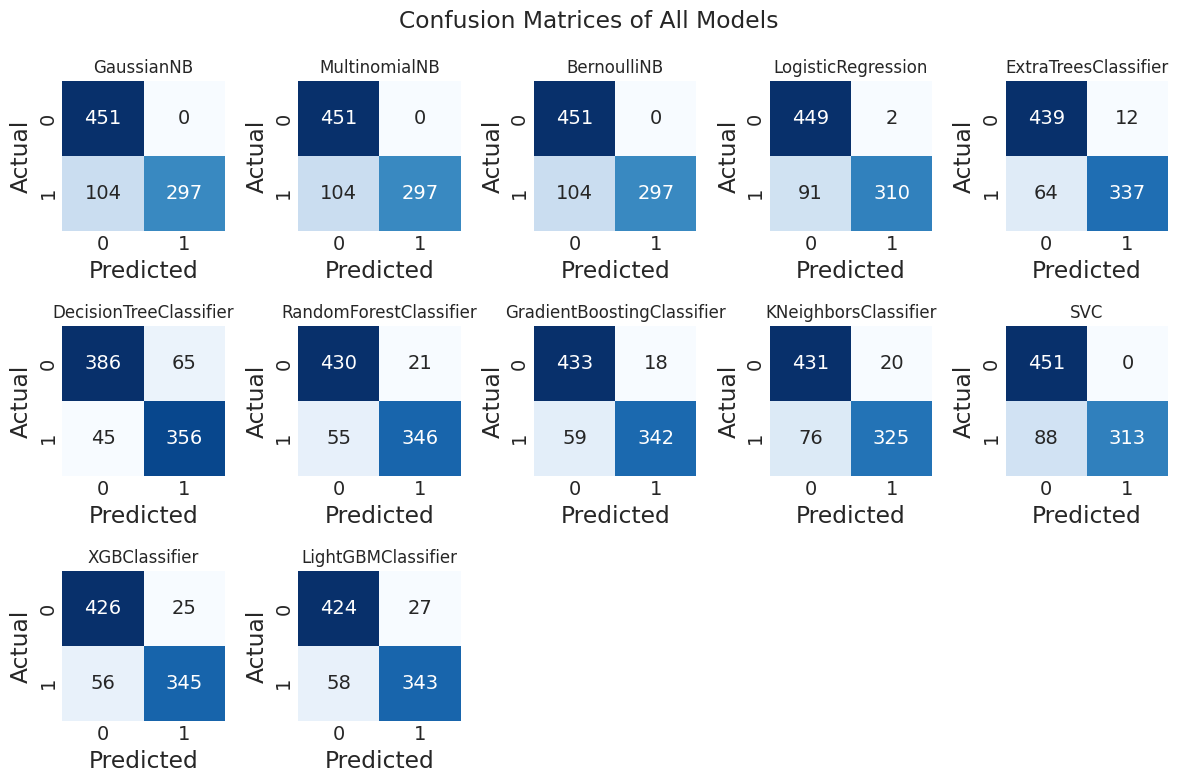

In [37]:
evaluate(x_train, y_train, x_test, y_test)

## 6. Build Pipeline with the best model, Save the model, Make Submission

In [40]:
preprocessor = ColumnTransformer([
    ('scaler', MinMaxScaler(), x.columns)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])
pipeline.fit(x, y)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scaler', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [42]:
y_pred = pipeline.predict(x)

In [43]:
confusion_matrix(y, y_pred)

array([[2129,    0],
       [   0, 2129]])

In [44]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2129
           1       1.00      1.00      1.00      2129

    accuracy                           1.00      4258
   macro avg       1.00      1.00      1.00      4258
weighted avg       1.00      1.00      1.00      4258



In [45]:
joblib.dump(pipeline, 'machine_failure_prediction.pkl')

['machine_failure_prediction.pkl']

In [46]:
test_df = pd.read_csv('test.csv', index_col='id')
predictions = pipeline.predict(test_df)
submission = pd.DataFrame({
    'id': test_df.index,
    'Machine failure': predictions
})
submission.head()

,id,Machine failure
0,136429,0
1,136430,0
2,136431,0
3,136432,0
4,136433,0


In [47]:
submission.to_csv('submission.csv', index=False)

## 7. Conclusion
We built a pipeline to predict machine failures using a `RandomForestClassifier`. We saved the pipeline and used it to make predictions on the test set. We also made a submission file for the Kaggle competition.